# HSIC Measures

In [22]:
import sys
sys.path.append("../../")

import jax
import jax.numpy as np
import numpy as onp
import pandas as pd
# from jax.config import config
# config.update("jax_enable_x64", True)


# dependence measures
from jaxkern.similarity.hsic import HSIC, CKA
from jaxkern.kernels.linear import Linear
from jaxkern.kernels.stationary import RBF
from jaxkern.kernels.sigma import estimate_sigma_median
from jaxkern.similarity.hsic import HSICRBFSampler, CKARBFSampler
from jaxkern.kernels.approx import RBFSampler
from jaxkern.kernels.sigma import estimate_sigma_median

# MATPLOTLIB Settings
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# SEABORN SETTINGS
import seaborn as sns
sns.set_context(context='talk',font_scale=0.7)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Toy Data

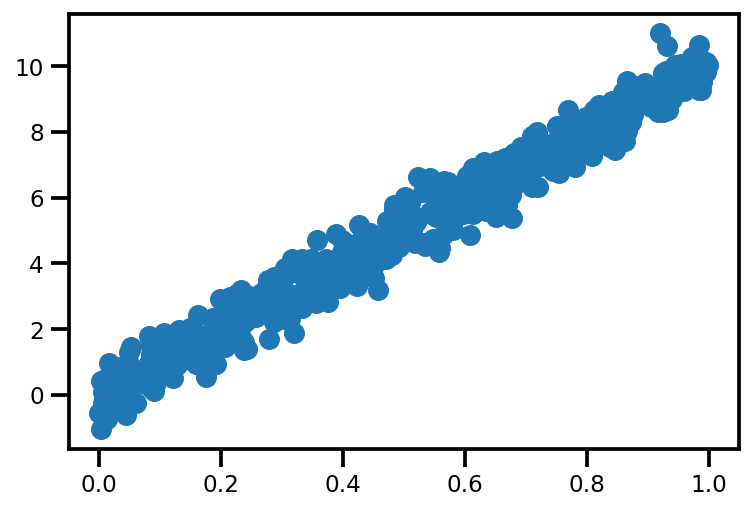

In [23]:
# random state
seed = 123
rng = onp.random.RandomState(seed)

# generate fake data
n_samples = 500
n_features = 1
noise_y = 0.5

X = rng.rand(n_samples, n_features)
Y = 10 * X + noise_y * rng.randn(n_samples, n_features)

X = np.array(X)
Y = np.array(Y)

plt.scatter(X, Y)

## Similarity Measures

## Similarity - Kernel-Based

In [24]:
# initialize kernel
lin_kern = Linear()
rbf_kern = RBF()

#### HSIC

In [25]:
import objax

# initialize HSIC
hsic_clf = HSIC(lin_kern, lin_kern)

hsic_val = hsic_clf(X, Y)

print(f"HSIC: {hsic_val:.4f}")

HSIC: 0.6760


##### Isotropic Scaled Data

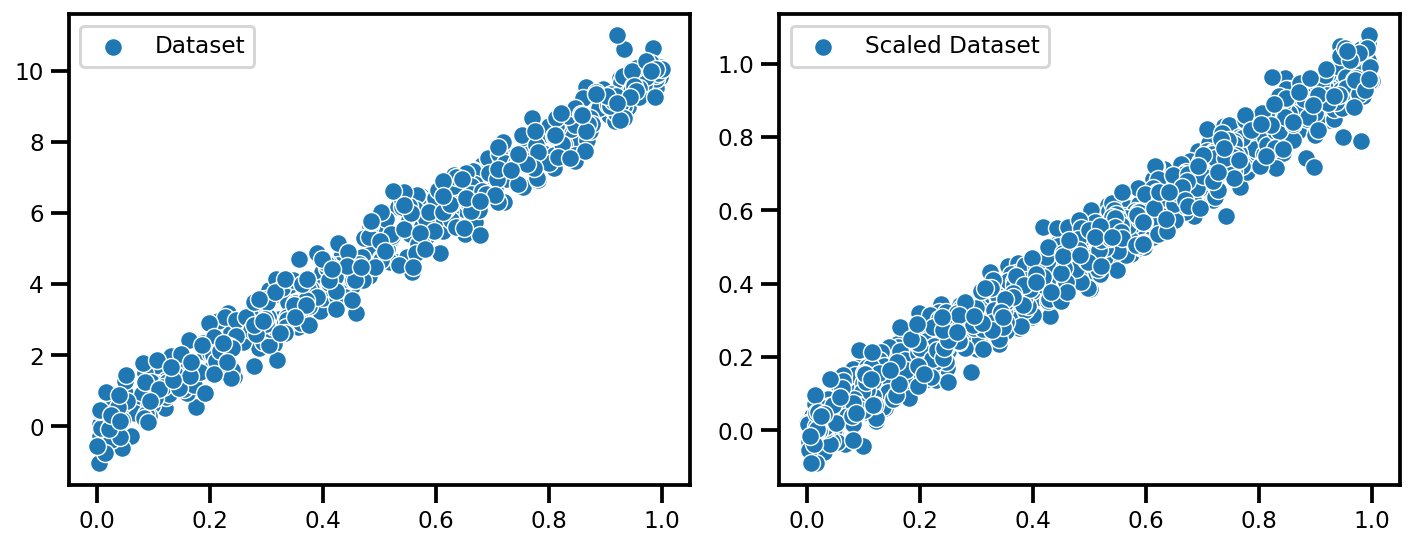

In [26]:
# random state
seed = 123
rng = onp.random.RandomState(seed)

# generate fake data
n_samples = 1000

X_s = rng.rand(n_samples, 1)
Y_s = X_s + 0.05 * rng.randn(n_samples, 1)

fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
sns.scatterplot(x=X_s.squeeze(), y=Y_s.squeeze(), ax=ax[1], label='Scaled Dataset');
sns.scatterplot(x=X.squeeze(), y=Y.squeeze(), ax=ax[0], label='Dataset');
plt.tight_layout()
plt.show()

In [27]:
# initialize HSIC
hsic_clf = HSIC(lin_kern, lin_kern)

hsic_val = hsic_clf(X_s, Y_s)

print(f"HSIC: {hsic_val:.4f}")

HSIC: 0.0065


In [29]:
from jaxkern.similarity.mmd import MMD_PXPY

In [8]:
hsic_clf = MMD_PXPY(lin_kern, lin_kern)

hsic_val = hsic_clf(X_s, Y_s)

print(f"HSIC: {hsic_val:.4f}")

HSIC: 0.0065


#### Centered Kernel Alignment

In [31]:
# initialize HSIC
cka_clf = CKA(lin_kern, lin_kern)

cka_val = cka_clf(X, Y)

print(f"CKA: {cka_val:.4f}")

cka_val = cka_clf(X_s, Y_s)

print(f"CKA (scaled): {cka_val:.4f}")

CKA: 0.9703
CKA (scaled): 0.9747


### HSIC, RBF Kernel

In [33]:
%%time
from jaxkern.kernels.stationary import RBF


length_scale_X = estimate_sigma_median(X_s[:1000], X_s[:1000])
length_scale_Y = estimate_sigma_median(Y_s[:1000], Y_s[:1000])

kernel_X = RBF(length_scale=length_scale_X)
kernel_Y = RBF(length_scale=length_scale_Y)


hsic_rbf_clf = HSIC(
    kernel_X=kernel_X, 
    kernel_Y=kernel_Y,
)

hsic_val = hsic_rbf_clf(X_s, Y_s)

print(f"HSIC (rbf): {hsic_val:.4f}")

HSIC (rbf): 0.0247
CPU times: user 855 ms, sys: 29.4 ms, total: 884 ms
Wall time: 893 ms


In [34]:
%%time
cka_rbf_clf = CKA(
    kernel_X=kernel_X, 
    kernel_Y=kernel_Y,
)

cka_val = cka_rbf_clf(X_s, Y_s)

print(f"CKA (rbf): {cka_val:.4f}")

CKA (rbf): 0.9580
CPU times: user 71.1 ms, sys: 17.5 ms, total: 88.6 ms
Wall time: 65.6 ms


#### JIT Compilation

In [35]:
cka_rbf_clf_jitted = objax.Jit(cka_rbf_clf)

In [38]:
cka_val = cka_rbf_clf_jitted(X_s, Y_s)

print(f"CKA (rbf): {cka_val:.4f}")

CKA (rbf): 0.9580


## HSIC, RBF Sampler

In [39]:
n_samples = 10_000

X_s = rng.rand(n_samples, 1)
Y_s = X_s + 0.05 * rng.randn(n_samples, 1)

X_s = np.array(X_s)
Y_s = np.array(Y_s)


length_scale_X = estimate_sigma_median(X_s[:1000], X_s[:1000])
length_scale_Y = estimate_sigma_median(Y_s[:1000], Y_s[:1000])


In [40]:
%%time


n_rff = 1000

hsic_rff_clf = HSICRBFSampler(
    length_scale_X=length_scale_X, 
    length_scale_Y=length_scale_Y,
    n_rff=n_rff
)



hsic_val = hsic_rff_clf(X_s, Y_s)

print(f"HSIC (rff): {hsic_val:.4f}")

HSIC (rff): 0.0600
CPU times: user 1.92 s, sys: 215 ms, total: 2.13 s
Wall time: 1.46 s


#### Jit Compilation

In [50]:
hsic_rff_clf_jitted = objax.Jit(hsic_rff_clf)

In [51]:
%%time

hsic_val = hsic_rff_clf_jitted(X_s, Y_s)

print(f"HSIC (rff): {hsic_val:.4f}")

HSIC (rff): 0.0586
CPU times: user 3.39 s, sys: 104 ms, total: 3.5 s
Wall time: 2.7 s


In [52]:
%%time

hsic_val = hsic_rff_clf_jitted(X_s, Y_s)

print(f"HSIC (rff): {hsic_val:.4f}")

HSIC (rff): 0.0584
CPU times: user 1.54 s, sys: 15.1 ms, total: 1.55 s
Wall time: 681 ms


In [54]:
%%time



n_rff = 1000

cka_rff_clf = CKARBFSampler(
    length_scale_X=length_scale_X, 
    length_scale_Y=length_scale_Y,
    n_rff=n_rff
)
hsic_val = cka_rff_clf(X_s, Y_s)

print(f"CKA (rff): {hsic_val:.4f}")

CKA (rff): 0.7198
CPU times: user 2.01 s, sys: 332 ms, total: 2.34 s
Wall time: 1.72 s


#### Jit Compilation

In [55]:
cka_rff_clf_jitted = objax.Jit(cka_rff_clf)

In [ ]:
%%time

cka_val = cka_rff_clf_jitted(X_s, Y_s)

print(f"CKA (rff): {cka_val:.4f}")

In [3]:
from jaxkern.kernels import rbf_kernel

results = {}

# kernels and kernel params
params_x = {'gamma': 1.0}
params_y = {'gamma': 1.0}
params_xy = {'gamma': 1.0}

# HSIC
results['hsic'] = hsic(
    X, 
    Y, 
    rbf_kernel, params_x, params_y)

print(f"HSIC: {results['hsic']:.4f}")

# Normalized HSIC (CKA)
results['cka'] = nhsic_cka(X, Y, rbf_kernel, params_x, params_y)

print(f"CKA: {results['cka']:.4f}")

# Normalized HSIC (CCA)
results['cca'] = nhsic_cca(X, Y, rbf_kernel, params_x, params_y)

print(f"CCA: {results['cca']:.4f}")

# ===========================
# Maxmimum Mean Discrepancy
# ===========================
# MMD
results['mmd_pxy'] = mmd_mi(X, Y, rbf_kernel, params_x, params_y)

print(f"MMD (pxy): {results['mmd_pxy']:.4f}")

# MMD
results['mmd_bias'] = mmd(X, Y, rbf_kernel, params_x, params_y, params_xy, bias=True)

print(f"MMD (biased): {results['mmd_bias']:.4f}")

# MMD
results['mmd'] = mmd(X, Y, rbf_kernel, params_x, params_y, params_xy, bias=False)

print(f"MMD (unbiased): {results['mmd']:.4f}")

# ==========================
# RV Coefficient
# ==========================

# RV
results['rv'] = rv_coeff(X, Y)

print(f"RV: {results['rv']:.4f}")

# Distance Correlation
results['dcorr'] = energy_distance(X, Y)

print(f"dCorr: {results['dcorr']:.4f}")

/home/emmanuel/.conda/envs/jaxkern/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


HSIC: 0.0149
CKA: 0.9744
CCA: 0.0000
MMD (pxy): 0.0149
MMD (biased): 0.0023
MMD (unbiased): 1.7276
RV: 0.9720
dCorr: 0.0000


## Kernel Parameters

In [4]:
from jaxkern.sigma import estimate_sigma_median, sigma_to_gamma
# from jaxkern.utils import 

results = {}

# kernels and kernel params
params_x = {'gamma': sigma_to_gamma(estimate_sigma_median(X, X))}
params_y = {'gamma': sigma_to_gamma(estimate_sigma_median(Y, Y))}
params_xy = {'gamma': sigma_to_gamma(estimate_sigma_median(X, Y))}

# Sigma Parameters
print(f"Sigma x: {params_x['gamma']:.4f}")
print(f"Sigma y: {params_y['gamma']:.4f}")
print(f"Sigma xy: {params_xy['gamma']:.4f}")

# HSIC
results['hsic'] = hsic(X, Y, rbf_kernel, params_x, params_y)

print(f"HSIC: {results['hsic']:.4f}")

# Normalized HSIC (CKA)
results['cka'] = nhsic_cka(X, Y, rbf_kernel, params_x, params_y)

print(f"CKA: {results['cka']:.4f}")

# Normalized HSIC (CCA)
results['cca'] = nhsic_cca(X, Y, rbf_kernel, params_x, params_y)

print(f"CCA: {results['cca']:.4f}")

# ===========================
# Maxmimum Mean Discrepancy
# ===========================
# MMD
results['mmd_pxy'] = mmd_mi(X, Y, rbf_kernel, params_x, params_y)

print(f"MMD (pxy): {results['mmd_pxy']:.4f}")

# MMD
results['mmd_bias'] = mmd(X, Y, rbf_kernel, params_x, params_y, params_xy, bias=True)

print(f"MMD (biased): {results['mmd_bias']:.4f}")

# MMD
results['mmd'] = mmd(X, Y, rbf_kernel, params_x, params_y, params_xy, bias=False)

print(f"MMD (unbiased): {results['mmd']:.4f}")

# ==========================
# RV Coefficient
# ==========================

# RV
results['rv'] = rv_coeff(X, Y)

print(f"RV: {results['rv']:.4f}")

# Distance Correlation
results['dcorr'] = energy_distance(X, Y)

print(f"dCorr: {results['dcorr']:.4f}")

Sigma x: 71.6559
Sigma y: 70.2248
Sigma xy: 71.4031
HSIC: 0.0826
CKA: 0.8248
CCA: 0.0000
MMD (pxy): 0.0825
MMD (biased): 0.0399
MMD (unbiased): 0.3896
RV: 0.9720
dCorr: 0.0000


## Non-LInear Function

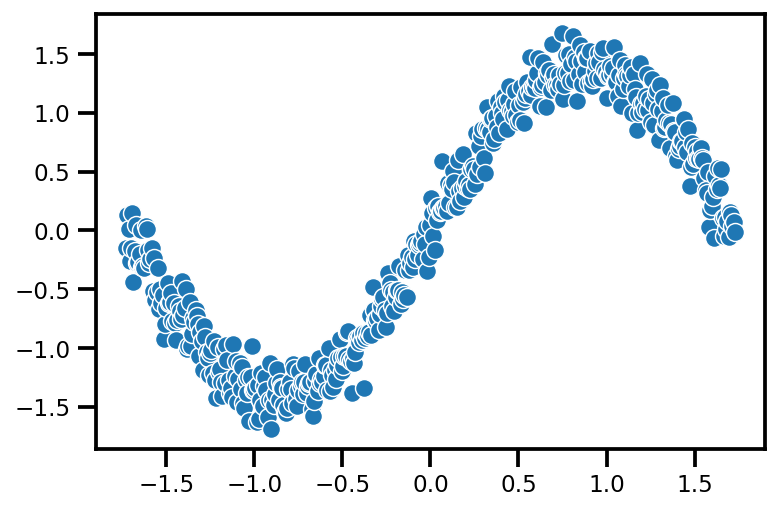

In [5]:
# random state
seed = 123
rng = onp.random.RandomState(seed)

# generate fake data
n_samples = 500

X = np.linspace(-2*np.pi, 2*np.pi, n_samples)
Y = np.sin(.5 * X) + 0.1 * rng.randn(n_samples)

X = (X - X.mean()) / X.std()
Y = (Y - Y.mean()) / Y.std()

sns.scatterplot(x=X, y=Y);

In [6]:
from jaxkern.kernels import rbf_kernel, ard_kernel
from jaxkern.sigma import estimate_sigma_median, sigma_to_gamma
# from jaxkern.utils import 

results = {}

# kernels and kernel params
params_x = {'gamma': sigma_to_gamma(estimate_sigma_median(X, X))}
params_y = {'gamma': sigma_to_gamma(estimate_sigma_median(Y, Y))}
params_xy = {'gamma': sigma_to_gamma(estimate_sigma_median(X, Y))}

# Sigma Parameters
print(f"Sigma x: {params_x['gamma']:.4f}")
print(f"Sigma y: {params_y['gamma']:.4f}")
print(f"Sigma xy: {params_xy['gamma']:.4f}")

# HSIC
results['hsic'] = hsic(X, Y, rbf_kernel, params_x, params_y)

print(f"HSIC: {results['hsic']:.4f}")

# Normalized HSIC (CKA)
results['cka'] = nhsic_cka(X, Y, rbf_kernel, params_x, params_y)

print(f"CKA: {results['cka']:.4f}")

# Normalized HSIC (CCA)
results['cca'] = nhsic_cca(X, Y, rbf_kernel, params_x, params_y)

print(f"CCA: {results['cca']:.4f}")


# ===========================
# Maxmimum Mean Discrepancy
# ===========================
# MMD
results['mmd_pxy'] = mmd_mi(X, Y, rbf_kernel, params_x, params_y)

print(f"\nMMD (pxy): {results['mmd_pxy']:.4f}")

# MMD
results['mmd_bias'] = mmd(X, Y, rbf_kernel, params_x, params_y, params_xy, bias=True)

print(f"MMD (biased): {results['mmd_bias']:.4f}")

# MMD
results['mmd'] = mmd(X, Y, rbf_kernel, params_x, params_y, params_xy, bias=False)

print(f"MMD (unbiased): {results['mmd']:.4f}")

# ==========================
# RV Coefficient
# ==========================

# RV
results['rv'] = rv_coeff(X, Y)

print(f"\nRV: {results['rv']:.4f}")

# Distance Correlation
results['dcorr'] = energy_distance(X, Y)

print(f"dCorr: {results['dcorr']:.4f}")

Sigma x: 0.4647
Sigma y: 0.4603
Sigma xy: 0.4694
HSIC: 0.0790
CKA: 0.7550
CCA: 0.0000

MMD (pxy): 0.0787
MMD (biased): 0.0826
MMD (unbiased): 1.1409

RV: 0.5958
dCorr: 0.0018


In [7]:
from jaxkern.kernels import rbf_kernel, ard_kernel
from jaxkern.sigma import estimate_sigma_median_kth, sigma_to_gamma
# from jaxkern.utils import 

results = {}

# kernels and kernel params
params_x = {'gamma': sigma_to_gamma(estimate_sigma_median_kth(X, X, 0.3)), 'var_f': 1.0}
params_y = {'gamma': sigma_to_gamma(estimate_sigma_median_kth(Y, Y, 0.3)), 'var_f': 1.0}
params_xy = {'gamma': sigma_to_gamma(estimate_sigma_median_kth(X, Y, 0.3)), 'var_f': 1.0}

# Sigma Parameters
print(f"Sigma x: {params_x['gamma']:.4f}")
print(f"Sigma y: {params_y['gamma']:.4f}")
print(f"Sigma xy: {params_xy['gamma']:.4f}")

# HSIC
results['hsic'] = hsic(X, Y, rbf_kernel, params_x, params_y)

print(f"HSIC: {results['hsic']:.4f}")

# Normalized HSIC (CKA)
results['cka'] = nhsic_cka(X, Y, rbf_kernel, params_x, params_y)

print(f"CKA: {results['cka']:.4f}")

# Normalized HSIC (CCA)
results['cca'] = nhsic_cca(X, Y, rbf_kernel, params_x, params_y)

print(f"CCA: {results['cca']:.4f}")

# ===========================
# Maxmimum Mean Discrepancy
# ===========================
# MMD
results['mmd_pxy'] = mmd_mi(X, Y, rbf_kernel, params_x, params_y)

print(f"\nMMD (pxy): {results['mmd_pxy']:.4f}")

# MMD
results['mmd_bias'] = mmd(X, Y, rbf_kernel, params_x, params_y, params_xy, bias=True)

print(f"MMD (biased): {results['mmd_bias']:.4f}")

# MMD
results['mmd'] = mmd(X, Y, rbf_kernel, params_x, params_y, params_xy, bias=False)

print(f"MMD (unbiased): {results['mmd']:.4f}")

# ==========================
# RV Coefficient
# ==========================

# RV
results['rv'] = rv_coeff(X, Y)

print(f"\nRV: {results['rv']:.4f}")
# Distance Correlation
results['dcorr'] = energy_distance(X, Y)

print(f"dCorr: {results['dcorr']:.4f}")

Sigma x: 6.8586
Sigma y: 7.0446
Sigma xy: 4.8034
HSIC: 0.0611
CKA: 0.5966
CCA: 0.0000

MMD (pxy): 0.0609
MMD (biased): 0.0000
MMD (unbiased): 0.3834

RV: 0.5958
dCorr: 0.0018
